In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

plt.style.use('seaborn')
warnings.filterwarnings('ignore')
%matplotlib inline

df = pd.read_csv('Mall_Customers.csv')
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [2]:
del df["CustomerID"] # ID 정보는 불필요하므로 제거

In [3]:
df.isnull().sum() # null값 존재하지 않음

Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [4]:
df['Gender'].unique()

array(['Male', 'Female'], dtype=object)

In [5]:
df['Gender'].replace({'Male':1, 'Female':0},inplace=True) # 문자형 데이터 encoding

In [6]:
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,19,15,39
1,1,21,15,81
2,0,20,16,6
3,0,23,16,77
4,0,31,17,40


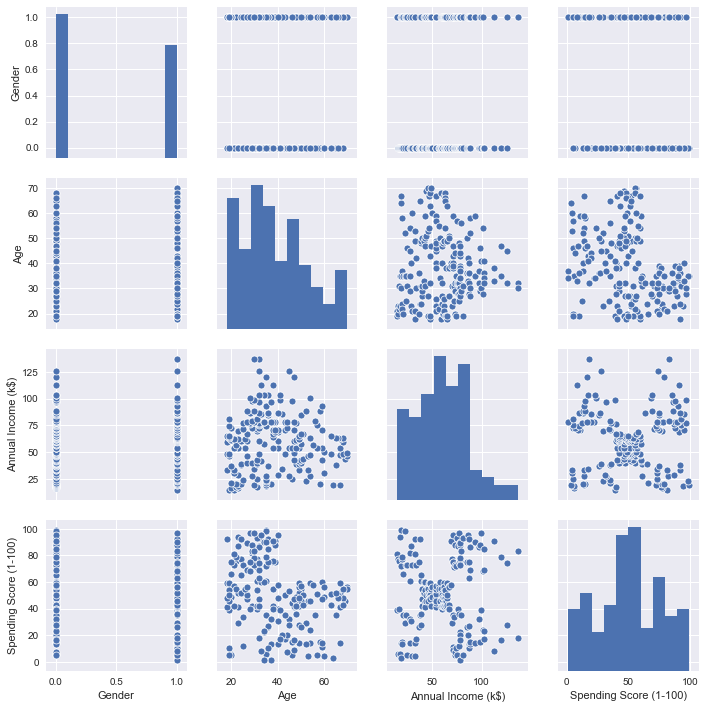

In [7]:
sns.pairplot(df)
plt.show()

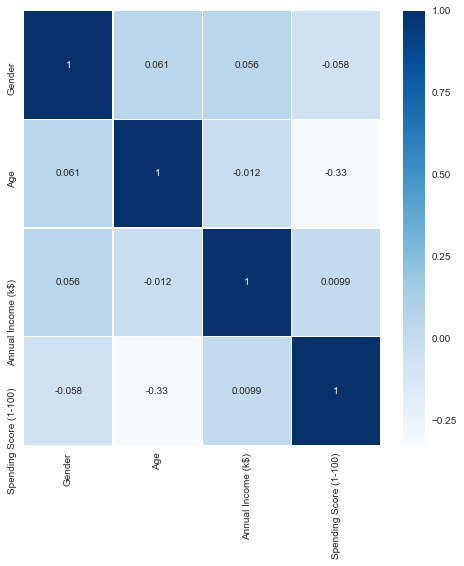

In [8]:
fig,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(df.corr(), ax=ax, annot=True, linewidths=.5 ,cmap="Blues")
plt.show()

# 변수 간 선형상관관계가 거의 없어보인다

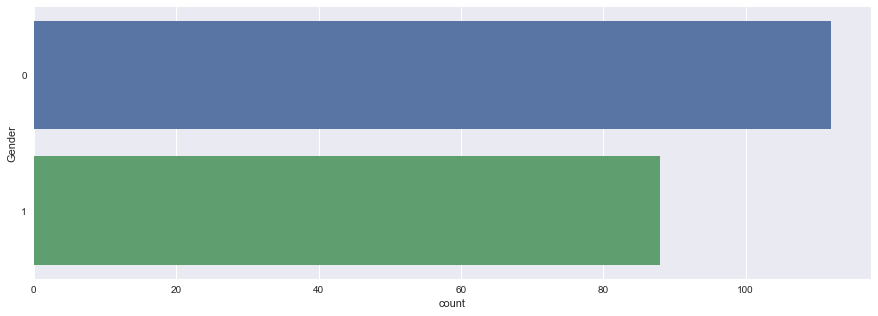

In [9]:
plt.figure(1 , figsize = (15 , 5))
sns.countplot(y = 'Gender' , data = df)
plt.show()

# Female인 경우가 더 많은 것을 알 수 있다.

In [10]:
from sklearn.decomposition import PCA

pca_reducer = PCA(n_components=2)
reduced_df = pca_reducer.fit_transform(df)
reduced_df.shape
# PCA 분석을 통해 변수들의 차원을 2차원으로 바꾸었다.

(200, 2)

In [11]:
# KMeans
from sklearn.cluster import KMeans

#K-Means 군집 분석 
km = KMeans(n_clusters=4,algorithm='auto')
cluster = km.fit(reduced_df)

Text(0.5, 1.0, 'Elbow curve')

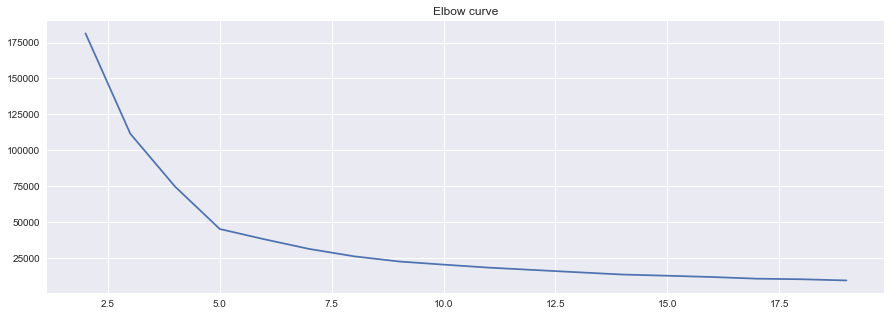

In [12]:
distortions = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(reduced_df)
    distortions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), distortions)
plt.grid(True)
plt.title('Elbow curve')

# k=5 일때 급격한 distortions의 변화가 일어난 것으로 보아
# cluster 수를 5로 설정하기로 하였다.

In [18]:
#K-Means 군집 분석 
km = KMeans(n_clusters=5, algorithm='auto')
cluster = km.fit(reduced_df)

In [22]:
reduced_df = pd.DataFrame(reduced_df)

In [23]:
cluster_id = pd.DataFrame(cluster.labels_)
d1 = pd.concat([reduced_df, cluster_id], axis=1)
d1.columns = [0, 1, "predict"]
d1.head()

,0,1,predict
0,-31.869945,-33.001252,3
1,0.764494,-56.842901,4
2,-57.408276,-13.124961,3
3,-2.168543,-53.478590,4
4,-32.174085,-30.388412,3


In [28]:
d1['predict'].unique()

array([3, 4, 0, 2, 1], dtype=int64)

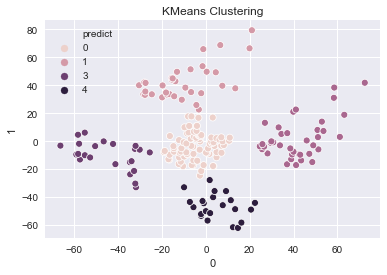

In [27]:
sns.scatterplot(d1[0], d1[1], hue = d1['predict'])
plt.title("KMeans Clustering")
plt.show()

In [62]:
#DBSCAN
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=8, min_samples=4)
cluster = db.fit(reduced_df)
cluster_id = pd.DataFrame(cluster.labels_)

d2 = pd.concat([reduced_df,cluster_id],axis=1)
d2.columns = [0, 1, "predict"]
d2.head()

,0,1,predict
0,-31.869945,-33.001252,-1
1,0.764494,-56.842901,0
2,-57.408276,-13.124961,1
3,-2.168543,-53.478590,0
4,-32.174085,-30.388412,-1


In [63]:
d2["predict"].unique()

array([-1,  0,  1,  2,  3,  4,  5], dtype=int64)

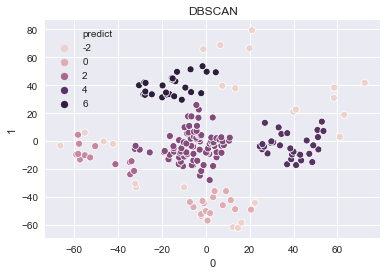

In [64]:
sns.scatterplot(d2[0], d2[1], hue = d2["predict"])
plt.title("DBSCAN")
plt.show()

In [88]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(reduced_df)
df_scaled = scaler.transform(reduced_df)
dbscan = DBSCAN()
clusters = dbscan.fit_predict(df_scaled)

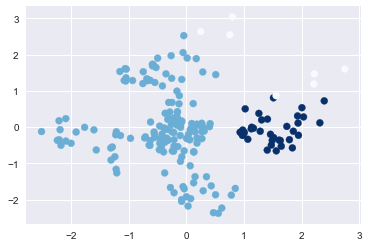

In [100]:
plt.scatter(df_scaled[:, 0], df_scaled[:, 1], c=clusters, cmap="Blues")
plt.show()

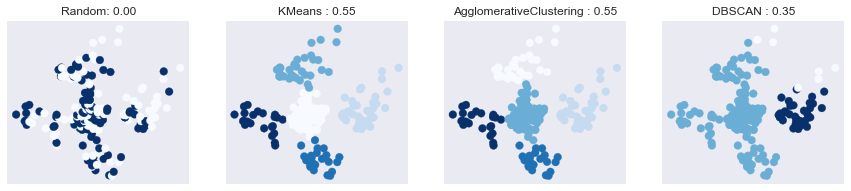

In [98]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import silhouette_score

fig, axes = plt.subplots(1, 4, figsize=(15, 3),
                         subplot_kw={'xticks': (), 'yticks': ()})

# 비교를 위해 무작위로 클러스터 할당
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(df))

# 무작위 할당한 클러스터 그리기
axes[0].scatter(df_scaled[:, 0], df_scaled[:, 1], c=random_clusters, s=60, cmap="Blues")
axes[0].set_title("Random: {:.2f}".format(
        silhouette_score(df_scaled, random_clusters)))

algorithms = [KMeans(n_clusters=5), AgglomerativeClustering(n_clusters=5),
              DBSCAN()]

for ax, algorithm in zip(axes[1:], algorithms):
    clusters = algorithm.fit_predict(df_scaled)
    ax.scatter(df_scaled[:, 0], df_scaled[:, 1], c=clusters,  s=60, cmap="Blues")
    ax.set_title("{} : {:.2f}".format(algorithm.__class__.__name__,
                                      silhouette_score(df_scaled, clusters)))

In [99]:
# KMeans와 AgglomerativeClustering의 실루엣 값이 제일 크므로 가장 타당한 군집화 결과임을 알 수 있다.